The `ResourceExhaustedError` you're encountering indicates that the GPU ran out of memory while trying to allocate a tensor. This can happen when working with large datasets or models that require a lot of memory.

There are several ways to address this issue, including reducing the batch size, reducing the size of your model, or using a more powerful GPU with more memory. You can also try using mixed precision training, which can reduce memory usage and speed up training by representing some of the tensors in lower precision.

Here's an example of how you can enable mixed precision training in TensorFlow:

```python
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
```

This code sets the global mixed precision policy to `'mixed_float16'`, which means that some of the tensors will be represented in lower precision to reduce memory usage and speed up training. You can try running this code before creating and training your model to see if it helps resolve the `ResourceExhaustedError`.

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [67]:
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [ ]:
# U slučaju slabe GPU, može se koristiti CPU. Nako n izvršavanja, potrebno je ponovno učitati tensorflow

# povratak na GPU:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


In [76]:
# Za vraćanje na float32
policy = mixed_precision.Policy('float32')
mixed_precision.set_global_policy(policy)

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [1]:
from PIL import Image
import os
import numpy as np
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
def resize_images(directory, size=(300, 300), ratio=False, metadata=False, extensions=('.jpg', '.png', '.JPG', '.PNG')):
    new_directory = os.path.join(directory, 'resized')
    if not os.path.exists(new_directory):
        os.makedirs(new_directory)
    for filename in os.listdir(directory):
        if filename.endswith(extensions):
            image = Image.open(os.path.join(directory, filename))
            if not metadata:
                # Remove metadata
                data = list(image.getdata())
                image = Image.new(image.mode, image.size)
                image.putdata(data)
            if ratio:
                width, height = image.size
                new_height = int(height * size[0] / width)
                image = image.resize((size[0], new_height))
            else:
                image = image.resize(size)
            image.save(os.path.join(new_directory, filename))

In [2]:
dir=os.path.join(os.getcwd(), 'Images')
s = (512,512)

In [5]:
resize_images(directory=dir, size=s, extensions=(".JPG"), ratio=False)

In [10]:
# set seed
np.random.seed(12340)

In [14]:
# Full-precision training
def load_images(directory, batch_size=100):
    images = []
    labels = []
    for i, filename in enumerate(os.listdir(directory)):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.JPG') or filename.endswith('.PNG'):
            image = tf.io.read_file(os.path.join(directory, filename))
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, s) # tu se isto mora prilagoditi input
            image = tf.image.convert_image_dtype(image, tf.float32)
            images.append(image)
            
            label = filename.split(' ')[0]
            labels.append(label)
        
        if (i + 1) % batch_size == 0 or (i + 1) == len(os.listdir(directory)):
            images = tf.stack(images)
            labels = tf.stack(labels)
            
            # Augmentacija udvostručuje broj slika nasumičnim rotacijama i horizontalnim preokretom
            data_augmentation = tf.keras.Sequential([
                tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
            ])
            
            augmented_images = data_augmentation(images)
            images = tf.concat([images, augmented_images], axis=0)
            labels = tf.concat([labels, labels], axis=0)
            
            yield images, labels
            images = []
            labels = []

#images, labels = load_images(os.path.join(dir, 'resized'), batch_size=16)

In [11]:
# plus k-means segmentation
def load_images(directory, batch_size=100):
    images = []
    labels = []
    for i, filename in enumerate(os.listdir(directory)):
        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.JPG') or filename.endswith('.PNG'):
            image = tf.io.read_file(os.path.join(directory, filename))
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, s) # tu se isto mora prilagoditi input
            image = tf.image.convert_image_dtype(image, tf.float32)
            
            # Perform image segmentation
            segmented_image = segment_image(image)
            
            # Append the original and segmented images to the list
            images.append(image)
            images.append(segmented_image)
            
            label = filename.split(' ')[0]
            labels.append(label)
            labels.append(label) # Append the label twice since we have two images
        
        if (i + 1) % batch_size == 0 or (i + 1) == len(os.listdir(directory)):
            images = tf.stack(images)
            labels = tf.stack(labels)
            
            # Augmentacija udvostručuje broj slika nasumičnim rotacijama i horizontalnim preokretom
            data_augmentation = tf.keras.Sequential([
                tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
            ])
            
            augmented_images = data_augmentation(images)
            images = tf.concat([images, augmented_images], axis=0)
            labels = tf.concat([labels, labels], axis=0)
            
            yield images, labels
            images = []
            labels = []
            
# experiment here with n_clusters for different results
def segment_image(image, n_clusters=3):
    # Reshape the image into a 2D array of pixels
    pixels = tf.reshape(image, (-1, 3))
    pixels = pixels.numpy()
    
    # Fit the KMeans model to the pixel data
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(pixels)
    
    # Replace each pixel value with its nearest cluster center
    segmented_pixels = kmeans.cluster_centers_[kmeans.labels_]
    segmented_pixels = segmented_pixels.reshape(image.shape)
    
    # Convert the segmented image back to a TensorFlow tensor
    segmented_image = tf.convert_to_tensor(segmented_pixels)
    
    return segmented_image

In [15]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
physical_devices = tf.config.list_physical_devices()
print("Available physical devices:", physical_devices)

# Check if a CPU device is available
cpu_devices = tf.config.list_physical_devices('CPU')
if len(cpu_devices) > 0:
    print("TensorFlow is running on the CPU")
else:
    print("TensorFlow is not running on the CPU")

Available physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow is running on the CPU


In [17]:
image_directory = os.path.join(dir, 'resized')

In [18]:
def encode_labels(labels):
    unique_labels, _ = tf.unique(labels)
    label_to_index = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(unique_labels, tf.range(tf.size(unique_labels))),
        -1
    )
    encoded_labels = label_to_index.lookup(labels)
    return encoded_labels.numpy() # Convert to NumPy array

all_images = []
all_labels = []
for images, labels in load_images(image_directory, batch_size=16):
    if images.shape[0] > 0: # Check if the batch is not empty
        all_images.append(images)
        all_labels.append(labels)

all_images = tf.concat(all_images, axis=0)
all_labels = tf.concat(all_labels, axis=0)

# Encode the labels
all_labels = encode_labels(all_labels)

# Reshape the images to 2D
all_images = tf.reshape(all_images, (all_images.shape[0], -1))

# Balance the classes using oversampling
ros = RandomOverSampler()
balanced_images, balanced_labels = ros.fit_resample(all_images.numpy(), all_labels)

# Convert the labels to integer type
balanced_labels = balanced_labels.astype(int)

# Convert the data to TensorFlow tensors
balanced_images = tf.convert_to_tensor(balanced_images)
balanced_labels = tf.convert_to_tensor(balanced_labels)

# Reshape the images back to 4D
balanced_images = tf.reshape(balanced_images, (-1, s[0], s[1], 3))

# Split the data into training and test sets
indices = tf.range(start=0, limit=balanced_images.shape[0], dtype=tf.int32)
train_indices, test_indices = tf.split(indices, num_or_size_splits=[int(0.8*balanced_images.shape[0]), int(0.2*balanced_images.shape[0])])
train_images = tf.gather(balanced_images, train_indices)
test_images = tf.gather(balanced_images, test_indices)
train_labels = tf.gather(balanced_labels, train_indices)
test_labels = tf.gather(balanced_labels, test_indices)

# Convert the data back to TensorFlow tensors
train_images = tf.convert_to_tensor(train_images)
test_images = tf.convert_to_tensor(test_images)
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate

class UNet(Model):
    def __init__(self, input_shape=(300, 300, 3), num_classes=10):
        super(UNet, self).__init__()

        # Encoder
        self.encoder = tf.keras.Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            MaxPooling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D((2, 2)),
            Conv2D(256, (3, 3), activation='relu'),
            MaxPooling2D((2, 2))
        ])

        # Bridge
        self.bridge = Conv2D(512, (3, 3), activation='relu')

        # Decoder
        self.decoder = tf.keras.Sequential([
            UpSampling2D((2, 2)),
            Conv2D(256, (3, 3), activation='relu'),
            Concatenate([self.decoder.output, self.encoder.layers[-3].output]),
            Conv2D(128, (3, 3), activation='relu'),
            UpSampling2D((2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            Concatenate([self.decoder.output, self.encoder.layers[-4].output]),
            Conv2D(32, (3, 3), activation='relu'),
            UpSampling2D((2, 2)),
            Conv2D(num_classes, (3, 3), activation='softmax')
        ])

    def call(self, inputs):
        encoder_output = self.encoder(inputs)
        bridge_output = self.bridge(encoder_output)
        decoder_output = self.decoder(bridge_output)

        return decoder_output

In [63]:
model = UNet()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=10)


AttributeError: 'UNet' object has no attribute 'decoder'

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)
# Load the new image
new_image = tf.io.read_file('new_image.jpg')
new_image = tf.image.decode_jpeg(new_image, channels=3)
new_image = tf.image.resize(new_image, s)
new_image = tf.image.convert_image_dtype(new_image, tf.float32)

# Make a prediction
prediction = model.predict(new_image)[0]

# Get the predicted class
predicted_class = tf.argmax(prediction)

# Print the predicted class
print('Predicted class:', predicted_class)


In [90]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, Cropping2D
from tensorflow.keras.models import Model

# Define the U-Net architecture
def unet(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    # Bottom
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    conv4_padded = ZeroPadding2D(padding=((1, 1), (1, 1)))(conv4)
    crop6 = Cropping2D(cropping=((0, 0), (0, 0)))(conv4_padded)

    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    crop6 = Cropping2D(cropping=((2, 1), (2, 1)))(conv4_padded)
    up6 = concatenate([up6, crop6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    
    up7 = Conv2DTranspose(256, (1,1), strides=(1, 2), padding='same')(conv6)
    crop7 = Cropping2D(cropping=((16, 16), (16, 16)))(conv3)  # Adjust cropping dimensions
    up7 = concatenate([up7, crop7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    crop8 = Cropping2D(cropping=((40, 40), (40, 40)))(conv2)  # Adjust cropping dimensions
    up8 = concatenate([up8, crop8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    crop9 = Cropping2D(cropping=((88, 88), (88, 88)))(conv1)  # Adjust cropping dimensions
    up9 = concatenate([up9, crop9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Create the U-Net model
input_shape = (300, 300, 3)
model = unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model using your training data
model.fit(train_images, train_labels, validation_data=(test_images, test_labels), epochs=epochs, batch_size=batch_size)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 36, 72, 256), (None, 43, 43, 256)]

In [57]:
s

(300, 300)

In [61]:
batch_size = 24
dataset = load_images(image_directory, batch_size)

# Define the U-Net model
input_shape = (s[0], s[1], 3)
model = unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
for images, labels in dataset:
    model.fit(train_images, train_labels, epochs=100)

TypeError: __init__() got multiple values for argument 'data_format'

In [54]:
# info about all loaded images
print('Number of images:', all_images.shape[0])
# average per channel rgb
print('Average per channel:', np.mean(all_images, axis=(0, 1)))
# standard deviation per channel
print('Standard deviation per channel:', np.std(all_images, axis=(0, 1)))
# min per channel
print('Min per channel:', np.min(all_images, axis=(0, 1)))
# max per channel
print('Max per channel:', np.max(all_images, axis=(0, 1)))



Number of images: 2400
Average per channel: 113.18425
Standard deviation per channel: 66.900085
Min per channel: 0.0
Max per channel: 255.0


In [ ]:
'''all_images = []
all_labels = []
for images, labels in load_images(os.path.join(os.getcwd(), 'resized'), batch_size=16):
    all_images.append(images)
    all_labels.append(labels)

all_images = tf.concat(all_images, axis=0)
all_labels = tf.concat(all_labels, axis=0)

# Encode the labels
all_labels = encode_labels(all_labels)

# Compute the class distribution
_, class_counts = tf.unique_with_counts(all_labels)
max_count = tf.reduce_max(class_counts)

# Oversample the minority classes
balanced_images = []
balanced_labels = []
for i in range(tf.size(class_counts)):
    class_mask = tf.equal(all_labels, i)
    class_images = tf.boolean_mask(all_images, class_mask)
    class_labels = tf.boolean_mask(all_labels, class_mask)
    
    num_samples = tf.shape(class_images)[0]
    num_extra_samples = max_count - num_samples
    
    extra_indices = tf.random.uniform((num_extra_samples,), minval=0, maxval=num_samples, dtype=tf.int32)
    extra_images = tf.gather(class_images, extra_indices)
    extra_labels = tf.gather(class_labels, extra_indices)
    
    balanced_images.append(tf.concat([class_images, extra_images], axis=0))
    balanced_labels.append(tf.concat([class_labels, extra_labels], axis=0))

balanced_images = tf.concat(balanced_images, axis=0)
balanced_labels = tf.concat(balanced_labels, axis=0)

# Split the data into training and test sets
num_samples = balanced_images.shape[0]
num_train_samples = int(num_samples * 0.8)

train_images = balanced_images[:num_train_samples]
train_labels = balanced_labels[:num_train_samples]

test_images = balanced_images[num_train_samples:]
test_labels = balanced_labels[num_train_samples:]
'''

In [17]:
# složeniji model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(s[0], s[1], 3)), # Tu promijeni size
        tf.keras.layers.MaxPooling2D((2, 2)),
        #tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    '''model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])'''
    
    return model

model = create_model()


history = model.fit(train_images, train_labels, batch_size=20, epochs=100)
'''
for images, labels in load_images(os.path.join(os.getcwd(), 'resized'), batch_size=16):
    labels = encode_labels(labels)
    model.fit(images, labels, batch_size = 32, epochs=5)'''

Epoch 1/100


2023-08-26 13:51:34.928637: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at sparse_xent_op.cc:103 : INVALID_ARGUMENT: Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 3 3 0 2 2 3 3 2 0 3 0 2 2 2 1 0 1 2 3 0


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 457, in dispatch_queue
      await self.process_one()
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 446, in process_one
      await dispatch(*args)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 353, in dispatch_shell
      await result
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 648, in execute_request
      reply_content = await reply_content
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/81/dk1hscqs2slg5m53bqfbpj8c0000gn/T/ipykernel_6343/805229020.py", line 29, in <module>
      history = model.fit(train_images, train_labels, batch_size=20, epochs=100)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/losses.py", line 1862, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "/Users/vlatko/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/keras/backend.py", line 5202, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 3 3 0 2 2 3 3 2 0 3 0 2 2 2 1 0 1 2 3 0
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_72187]

In [14]:
s

(128, 128)

In [15]:
# YOLO model with  24 convolutional layers followed by 2 fully connected layers (FC). Some convolution layers use 1 × 1 reduction layers alternatively to reduce the depth of the features maps. For the last convolution layer, it outputs a tensor with shape (7, 7, 1024)
def create_yolo():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(s[0], s[1], 3)), # Tu promijeni size
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dense(1470, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model
    

In [16]:
yolo = create_yolo()
yolo_history = yolo.fit(train_images, train_labels, batch_size=20, epochs=100)


ValueError: Exception encountered when calling layer "conv2d_12" (type Conv2D).

Negative dimension size caused by subtracting 3 from 2 for '{{node conv2d_12/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](Placeholder, conv2d_12/Conv2D/ReadVariableOp)' with input shapes: [?,2,2,256], [3,3,256,512].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 2, 2, 256), dtype=float32)

In [20]:
# plot the model tensorflow
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
#save the model and weights
model.save('model.h5')
# save history = model.fit(train_images, train_labels, batch_size=20, epochs=100)
history.save('history.h5')


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


AttributeError: 'History' object has no attribute 'save'

In [125]:
# CV model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import ModelCheckpoint

def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)), # Tu promijeni size
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        #tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
    
# Define the number of folds
k = 5

# Split the data into K folds
kf = KFold(n_splits=k, shuffle=True)

# Initialize an empty list to store the accuracy scores for each fold
scores = []


    
# Initialize an empty list to store the models for each fold
models = []

# Loop over the folds
for train_index, test_index in kf.split(train_images):
    # Convert the indices to integer type
    train_index = train_index.astype(int)
    test_index = test_index.astype(int)
    
    # Split the data into training and testing sets for this fold
    X_train, X_test = tf.gather(train_images, train_index), tf.gather(train_images, test_index)
    y_train, y_test = tf.gather(train_labels, train_index), tf.gather(train_labels, test_index)    
    # Create the model
    model = create_model()
    
    # Define the checkpoint filename for this fold
    checkpoint_filename = 'model_fold_' + str(len(models)) + '.h5'
    
    # Define the checkpoint callback to save the best model during training
    checkpoint_callback = ModelCheckpoint(checkpoint_filename, monitor='val_accuracy', save_best_only=True, mode='max')
    
    # Train the model on the training data for this fold
    model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint_callback])
    
    # Load the best model from the checkpoint file
    model.load_weights(checkpoint_filename)
    
    # Evaluate the model on the testing data for this fold
    score = model.evaluate(X_test, y_test)
    
    # Append the accuracy score to the list of scores
    scores.append(score[1])
    
    # Append the model to the list of models
    models.append(model)
    
# Calculate the mean and standard deviation of the accuracy scores
mean_score = np.mean(scores)
std_score = np.std(scores)

print('Mean accuracy:', mean_score)
print('Standard deviation:', std_score)

# Select the best model based on the mean accuracy score
best_model_index = np.argmax(scores)
best_model = models[best_model_index]

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'sequential_1455/conv2d_132/Conv2D' defined at (most recent call last):
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 357, in dispatch_shell
      await result
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2768, in run_cell
      result = self._run_cell(
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 2814, in _run_cell
      return runner(coro)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Korisnik\AppData\Local\Temp\ipykernel_23624\1604357493.py", line 57, in <module>
      model.fit(X_train, y_train, batch_size=16, epochs=50, validation_data=(X_test, y_test), callbacks=[checkpoint_callback])
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\engine\sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 250, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 225, in convolution_op
      return tf.nn.convolution(
Node: 'sequential_1455/conv2d_132/Conv2D'
OOM when allocating tensor with shape[16,128,96,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential_1455/conv2d_132/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1563836]

In [124]:
scores

[0.4114583432674408]

In [119]:
type(train_labels)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
# ovaj radi i grid search

# Define the number of folds
k = 5

# Define the hyperparameters to search over
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Split the data into K folds
kf = KFold(n_splits=k, shuffle=True)

# Initialize an empty list to store the accuracy scores for each fold
scores = []

# Loop over the hyperparameters
for batch_size in param_grid['batch_size']:
    for epochs in param_grid['epochs']:
        for learning_rate in param_grid['learning_rate']:
            # Loop over the folds
            for train_index, test_index in kf.split(train_images):
                # Split the data into training and testing sets for this fold
                X_train, X_test = train_images[train_index], train_images[test_index]
                y_train, y_test = train_labels[train_index], train_labels[test_index]

                # Create the model
                model = create_model()

                # Set the hyperparameters
                model.optimizer.learning_rate = learning_rate

                # Train the model on the training data for this fold
                model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

                # Evaluate the model on the testing data for this fold
                score = model.evaluate(X_test, y_test)

                # Append the accuracy score to the list of scores
                scores.append(score[1])

            # Calculate the mean and standard deviation of the accuracy scores for this set of hyperparameters
            mean_score = np.mean(scores)
            std_score = np.std(scores)

            # Print the hyperparameters and the corresponding mean accuracy and standard deviation
            print('batch_size:', batch_size, 'epochs:', epochs, 'learning_rate:', learning_rate, 'mean accuracy:', mean_score, 'standard deviation:', std_score)

In [53]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

30/30 [==============================] - 1s 49ms/step
Test accuracy: 0.18
Test precision: 0.33
Test recall: 0.06
Test F1-score: 0.10


c:\Users\Korisnik\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


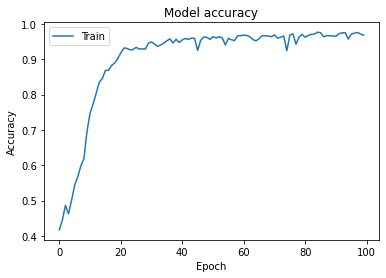

In [22]:
# Evaluate the model on the test dataset
test_predictions = model.predict(test_images)
test_predictions = tf.argmax(test_predictions, axis=1)

# Compute the evaluation metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions, average='macro')
test_recall = recall_score(test_labels, test_predictions, average='macro')
test_f1_score = f1_score(test_labels, test_predictions, average='macro')

# Print the evaluation metrics
print(f'Test accuracy: {test_accuracy:.2f}')
print(f'Test precision: {test_precision:.2f}')
print(f'Test recall: {test_recall:.2f}')
print(f'Test F1-score: {test_f1_score:.2f}')

# Plot the model's learning metrics
#history = model.history
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
